<a href="https://colab.research.google.com/github/aruntakhur/PyTorch_NLP_Vision_New/blob/main/Chapter4_QA_NLP_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install -q transformers
!pip install -q datasets

In [69]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", "electronics")

WARNING - datasets.builder -  Reusing dataset subjqa (/root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
import pandas as pd

subjqa.set_format("pandas")
# Flatten the nested dataset columns for easy access
dfs = {split:ds[:] for split, ds in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [71]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
print(sample_df)

           title  ...                                                                          context
791   B005DKZTMG  ...  I really like this keyboard.  I give it 4 stars because it doesn't have a CA...
1159  B00AAIPT76  ...  I bought this after the first spare gopro battery I bought wouldn't hold a c...

[2 rows x 5 columns]


In [72]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

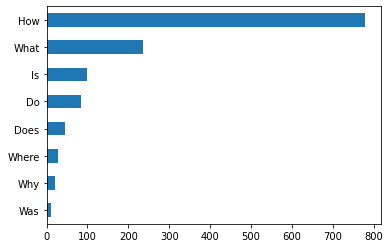

In [73]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh();

In [74]:
'''for question_type in ["How", "What", "Is"]:
    str = f"question.str.startswith('{question_type}')"
    for question in (dfs["train"]
                     .query("What")
                     .sample(n=3, random_state=42)['question']):
        print(question)
    print()'''

'for question_type in ["How", "What", "Is"]:\n    str = f"question.str.startswith(\'{question_type}\')"\n    for question in (dfs["train"]\n                     .query("What")\n                     .sample(n=3, random_state=42)[\'question\']):\n        print(question)\n    print()'

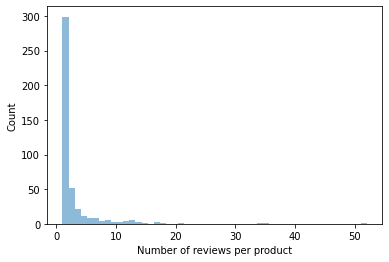

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
(dfs["train"].groupby("title")["review_id"].nunique()
 .hist(bins=50, alpha=0.5, grid=False, ax=ax))
plt.xlabel("Number of reviews per product")
plt.ylabel("Count");

In [76]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [77]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [78]:
inputs
tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

['[CLS]',
 'how',
 'much',
 'music',
 'can',
 'this',
 'hold',
 '?',
 '[SEP]',
 'an',
 'mp3',
 'is',
 'about',
 '1',
 'mb',
 '/',
 'minute',
 ',',
 'so',
 'about',
 '6000',
 'hours',
 'depending',
 'on',
 'file',
 'size',
 '.',
 '[SEP]']

In [79]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [80]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

In [81]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
outputs = model(**inputs)

In [82]:
start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [83]:
import torch

start_idx = torch.argmax(start_scores)
end_idx = torch.argmax(end_scores) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In Transformers, all of these pre-processing and post-processing steps are conveniently wrapped in a dedicated QuestionAnsweringPipeline. We can instantiate the pipeline by passing our tokenizer and fine-tuned model as follows

In [84]:
from transformers import QuestionAnsweringPipeline

pipe = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'answer': '6000 hours',
  'end': 48,
  'score': 0.26516255736351013,
  'start': 38},
 {'answer': '1 MB/minute, so about 6000 hours',
  'end': 48,
  'score': 0.2208293378353119,
  'start': 16},
 {'answer': '1 MB/minute',
  'end': 27,
  'score': 0.10253478586673737,
  'start': 16}]

In [85]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [86]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [87]:
for window in tokenized_example["input_ids"]:
    print(tokenizer.decode(window), "\n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



In [88]:
#!pip install farm-haystack
!pip install transformers==4.7.0
!pip install git+https://github.com/deepset-ai/haystack.git
!pip install torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

  Using cached transformers-4.7.0-py3-none-any.whl (2.5 MB)
  Using cached huggingface_hub-0.0.8-py3-none-any.whl (34 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.2.1
    Uninstalling huggingface-hub-0.2.1:
      Successfully uninstalled huggingface-hub-0.2.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.13.0
    Uninstalling transformers-4.13.0:
      Successfully uninstalled transformers-4.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.17.0 requires huggingface-hub<1.0.0,>=0.1.0, but you have huggingface-hub 0.0.8 which is incompatible.


  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-iflelrwx
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-iflelrwx
  Using cached transformers-4.13.0-py3-none-any.whl (3.3 MB)
  Using cached huggingface_hub-0.2.1-py3-none-any.whl (61 kB)
  Using cached torch-1.10.0-cp37-cp37m-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.8
    Uninstalling huggingface-hub-0.0.8:
      Successfully uninstalled huggingface-hub-0.0.8
  Attempting uninstall: transformers
    Found existing installation: transformers 4.7.0
    Uninstalling transformers-4.7.0:
      Successfully uninstalled transformers-4.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages th

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.6.0%2Bcu101-cp37-cp37m-linux_x86_64.whl (708.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
farm-haystack 1.0.0 requires transformers==4.7.0, but you have transformers 4.13.0 which is incompatible.


In [89]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [90]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [91]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "4ebb2da8cb22",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "cpj1iLuST0SPeazqCEJsuA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [92]:
!pip install grpcio==1.37.1
!pip install grpcio-tools==1.37.1

In [93]:
!pip show grpcio

Name: grpcio
Version: 1.37.1
Summary: HTTP/2-based RPC framework
Home-page: https://grpc.io
Author: The gRPC Authors
Author-email: grpc-io@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: six
Required-by: tensorflow, tensorboard, ray, pymilvus, grpcio-tools


In [94]:
pip install 'ray[default]'

In [95]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [96]:
for split, df in dfs.items():
  print(split, df)

train            domain  ... answers.is_ans_subjective
0     electronics  ...                        []
1     electronics  ...              [True, True]
2     electronics  ...                    [True]
3     electronics  ...                   [False]
4     electronics  ...            [False, False]
...           ...  ...                       ...
1290  electronics  ...                        []
1291  electronics  ...                        []
1292  electronics  ...                        []
1293  electronics  ...              [True, True]
1294  electronics  ...                    [True]

[1295 rows x 19 columns]
test           domain      nn_mod  ... answers.ans_subj_score answers.is_ans_subjective
0    electronics  comparable  ...                  [0.8]                    [True]
1    electronics       other  ...                     []                        []
2    electronics      better  ...                     []                        []
3    electronics       heavy  ...          

In [97]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],
             "meta":{"item_id": row["title"], "qid": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


In [98]:
''' {'content': 'the view is so good and clear and so easy to focus in and light not heavy must get you a pair',
  'meta': {'item_id': 'B00004SABB',
   'qid': '47110eb7720cffd03bb78f609999243d',
   'split': 'validation'}}'''
#docs

" {'content': 'the view is so good and clear and so easy to focus in and light not heavy must get you a pair',\n  'meta': {'item_id': 'B00004SABB',\n   'qid': '47110eb7720cffd03bb78f609999243d',\n   'split': 'validation'}}"

In [99]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

In [100]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [101]:
retrieved_docs

[<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'qid': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>,
 <Document: {'content': 'Plays Netflix great, WiFi capability has great range. Resolution on the screen is AMAZING! For the price you cannot go wrong. Bought one for my spouse and myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when

In [102]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/minilm-uncased-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/minilm-uncased-squad2
INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0    0 
INFO - haystack.modeling.infer -  /w\  /w\
INFO - haystack.modeling.infer -  /'\  / \


In [103]:
question = 'How much music can this hold?'

In [104]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648086071014404, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293046683073044, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id': 'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


In [161]:
from haystack.schema import Answer, Document, Label, Span
from haystack.schema import EvaluationResult, MultiLabel
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [167]:
n_answers = 3
#preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers, filters={"item_id": [item_id], "split":["train"]})
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": n_answers},"filters":{"item_id": [item_id], "split":["train"]}})
print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





In [119]:
preds

{'answers': [<Answer {'answer': 'This is a good tablet for reading books', 'type': 'extractive', 'score': 0.6662688255310059, 'context': ' I expect of a tablet.The text is very clear and sharp. This is a good tablet for reading books, which is more than I expected.There is the one small ', 'offsets_in_document': [{'start': 196, 'end': 235}], 'offsets_in_context': [{'start': 56, 'end': 95}], 'document_id': '12816e24def1d783b8fca3fbd7cb28a1', 'meta': {'item_id': 'B00DVFLJDS', 'qid': 'f9a7e7eb40501bf4a2bda84799f6fdd0', 'split': 'train'}}>,
  <Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5443064421415329, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t', 'offsets_in_document': [{'start': 216, 'end': 272}], 'offsets_in_context': [{'start': 47, 'end': 103}], 'document_id': '41f4a1710c6f3be65c7814326b662ab6', 'meta

In [162]:
xx = preds['answers'][0]
xx.context

' I expect of a tablet.The text is very clear and sharp. This is a good tablet for reading books, which is more than I expected.There is the one small '

{'answers': [<Answer {'answer': 'This is a good tablet for reading books', 'type': 'extractive', 'score': 0.6662688255310059, 'context': ' I expect of a tablet.The text is very clear and sharp. This is a good tablet for reading books, which is more than I expected.There is the one small ', 'offsets_in_document': [{'start': 196, 'end': 235}], 'offsets_in_context': [{'start': 56, 'end': 95}], 'document_id': '12816e24def1d783b8fca3fbd7cb28a1', 'meta': {'item_id': 'B00DVFLJDS', 'qid': 'f9a7e7eb40501bf4a2bda84799f6fdd0', 'split': 'train'}}>,
             <Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5443064421415329, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t', 'offsets_in_document': [{'start': 216, 'end': 272}], 'offsets_in_context': [{'start': 47, 'end': 103}], 'document_id': '41f4a1710c6f3be65c7814326b662